# Day 3
## Optimizers
- implement SGD, Momentum (with Nesterov lookup), AdamW

### SGD
At each training step, given parameters $\theta$ (weights), gradient $g = \nabla_\theta L(\theta)$ and a learning rate $\eta$, take: 
$$ \theta \leftarrow \theta - \eta g $$


In [2]:
from optimizers import SGD

### Momentum 
Momentum beats on problems with strong curvature anisotropy (ravines/ill conditioning) or saddle-heavy landscapes.

At each training step, compute the effective gradient as: 
$$v = \beta v + (1- \epsilon) \nabla_\theta L$$ 
$$ g_\text{eff} = v$$ 
if momentum or 
$$g_\text{eff} = \nabla_\theta L + \beta v$$
if Nesterov momentum (lookahead). Again apply 

$$ \theta = \theta - \eta g_\text{eff}$$


In [3]:
from optimizers import Momentum

### AdamW

Adam uses a momentum update for each parameter $i$. 
$$ 
m_i = \beta_1 m_i + (1-\beta_1) g
$$

It also uses RMSProp; exponential moving average for squared gradients. 
$$ 
v_i = \beta_2 v_i + (1 - \beta_2) g^2
$$

The algorithm keeps track of the number of steps it took - $t$. Bias correction: 
$$ 
\hat{m} = m_i / (1 - \beta_1^t) \\ 
\hat{v} = v_i / (1-\beta_2^t)
$$

Update
$$
\theta -= \eta \hat{m}/(\sqrt{\hat{v}}+\epsilon)  + (\text{weight decay}) \cdot \theta
$$


In [4]:
from optimizers import AdamW

## Comparison

In [5]:
import numpy as np

def random_orthogonal_matrix(n: int, seed:int | None = None) -> np.ndarray:
    """Haar-random orthogonal matrix via QR decomposition.
    Ensure positive diagonal in R to fix sign ambiguity.

    Args:
        n (int): dimension of the matrix
        seed (int | None, optional): RNG seed. Defaults to None.
    
    Returns:
        np.ndarray: random orthogonal matrix of shape (n, n)

    """  # noqa: D205
    rng = np.random.default_rng(seed)
    gaussian = rng.standard_normal((n, n))
    Q, R = np.linalg.qr(gaussian)

    signs = np.sign(np.diag(R))
    signs[signs == 0] = 1  # Handle zero diagonal elements
    Q = Q * signs 
    return Q


def make_rot_quadratic(d = 100, 
                       kappa = 1e4, 
                       seed: int | None = 0):
    """Return (f, grad, H) for f(w) = 0.5 w^T H w, where
    H = Q^T diag(lambdas) Q with cond(H) = kappa.

    Args:
        d (int, optional): dimension. Defaults to 100.
        kappa (_type_, optional): condition number: largest/smallest egv. Defaults to 1e4.
        seed (int | None, optional): RNG seed. Defaults to 0.

    Returns:
        f (callable): function to evaluate
        grad (callable): gradient of the function
        H (np.ndarray): Hessian matrix

    """  # noqa: D205
    Q = random_orthogonal_matrix(d, seed)
    lambdas = np.linspace(1.0, kappa, d)
    H = Q.T @ np.diag(lambdas) @ Q 

    def f(w:np.ndarray) -> float:
        """Quadratic function."""
        return 0.5 * w.T @ H @ w

    def grad(w:np.ndarray) -> np.ndarray:
        """Gradient of the quadratic function."""
        w = np.asarray(w)
        return H @ w

    return f, grad, H


### Visualisation in d = 2

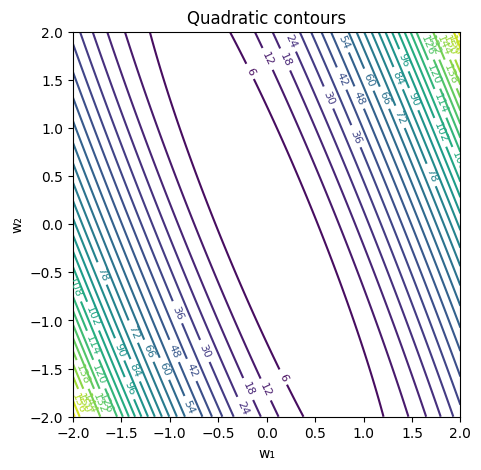

In [6]:
import matplotlib.pyplot as plt

f, grad, H = make_rot_quadratic(d=2, kappa=50, seed=42)

# Grid
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        w = np.array([X[i, j], Y[i, j]])
        Z[i, j] = f(w)

plt.figure(figsize=(5,5))
cs = plt.contour(X, Y, Z, levels=30, cmap="viridis")
plt.clabel(cs, inline=1, fontsize=8)
plt.xlabel("w₁"); plt.ylabel("w₂")
plt.title("Quadratic contours")
plt.show()

### Test

In [61]:
def run_optimizer(optimizer: SGD | Momentum | AdamW, 
                  f,
                  gradients,
                  initial_w,
                  lr = 1e-3,
                  steps=10000):
    # 1. Value is a parameter vector! 
    history = []
    for _ in range(steps):
        # 2. Compute gradients before taking a step and feed them in
        optimizer.params[0]["grad"][:] = gradients(optimizer.params[0]["value"])
        history.append(f(optimizer.params[0]["value"]))
        optimizer.step()
        optimizer.zero_grad()

    history.append(f(optimizer.params[0]["value"]))
    return history

# Note: Explosion - LR too large
d = 100
f, grad, _ = make_rot_quadratic(d=d)
rng = np.random.default_rng(1)
initial_w = rng.standard_normal(size=d)
steps = 20000
lr = 1e-4

# --- SGD Optimizer ---
sgd_optimizer = SGD(
    params=[{"value": initial_w, "grad": np.zeros_like(initial_w)}],
    lr=lr
)

sgd_history = run_optimizer(sgd_optimizer, f, grad, initial_w=initial_w, lr=lr, steps=steps)


# --- Momentum Optimizer ---
momentum_optimizer = Momentum(
    params=[{"value": initial_w, "grad": np.zeros_like(initial_w)}],
    lr=lr,
    beta=0.9,
    nesterov=True,
    weight_decay=0.01
)

momentum_history = run_optimizer(momentum_optimizer, f, grad, initial_w=initial_w, lr=lr, steps=steps)

# --- AdamW Optimizer ---
adamw_optimizer = AdamW(
    params=[{"value": initial_w, "grad": np.zeros_like(initial_w)}],
    lr=lr,
    betas=[0.9, 0.999],
    eps=1e-5,
    weight_decay=0.01
)
adamw_history = run_optimizer(adamw_optimizer, f, grad, initial_w=initial_w, lr=lr, steps=steps)

Text(0.5, 1.0, 'Convergence of Optimizers')

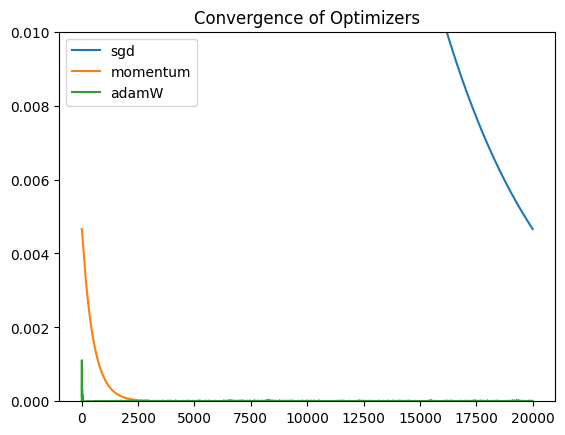

In [66]:
fig, ax = plt.subplots()

ax.plot(sgd_history, label="sgd")
ax.plot(momentum_history, label="momentum")
ax.plot(adamw_history, label="adamW")
plt.ylim(0,0.01)
plt.legend()
plt.title("Convergence of Optimizers")